In [1]:
import os
import copy
import time
import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

from data import get_data_as_dataframe
from plots import show_df, show_dl, plot_acc_loss_curve
from utils import custom_train_test_split, calculate_mean_std

# from models import vit

from train import train

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

PyTorch Version:  2.3.1+cu121
Torchvision Version:  0.18.1+cu121


In [2]:
# ROOT path
ROOT = os.getcwd()

# Training mode
PRETRAINED = True

# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

# Data Preparation

In [3]:
# Path to datasets
DATA_PATH = os.path.join(ROOT, 'dataset')

# Dataset name
DATASET_NAME = 'SDNET2018'

df = get_data_as_dataframe(DATA_PATH, dataset_name=DATASET_NAME, balance=True)
df.head()

,image,label
0,c:\Users\r.fatali\Desktop\Fine-tune ViT on Cra...,cracked
1,c:\Users\r.fatali\Desktop\Fine-tune ViT on Cra...,cracked
2,c:\Users\r.fatali\Desktop\Fine-tune ViT on Cra...,cracked
3,c:\Users\r.fatali\Desktop\Fine-tune ViT on Cra...,cracked
4,c:\Users\r.fatali\Desktop\Fine-tune ViT on Cra...,cracked


In [4]:
# define the train & test split
TEST_SIZE = 0.2

train_df, valid_df, test_df = custom_train_test_split(df, test_size=TEST_SIZE, stratify='label')

print(f"Train size: {train_df.shape}")
print(f"Validation size: {valid_df.shape}")
print(f"Test size: {test_df.shape}")

Train size: (4172, 2)
Validation size: (783, 2)
Test size: (261, 2)


In [5]:
print(f"Train data balance:\n {train_df.label.value_counts()}\n")
print(f"Validation data balance:\n {valid_df.label.value_counts()}\n")
print(f"Test data balance:\n {test_df.label.value_counts()}\n")

Train data balance:
 non-cracked    2086
cracked        2086
Name: label, dtype: int64

Validation data balance:
 non-cracked    392
cracked        391
Name: label, dtype: int64

Test data balance:
 cracked        131
non-cracked    130
Name: label, dtype: int64



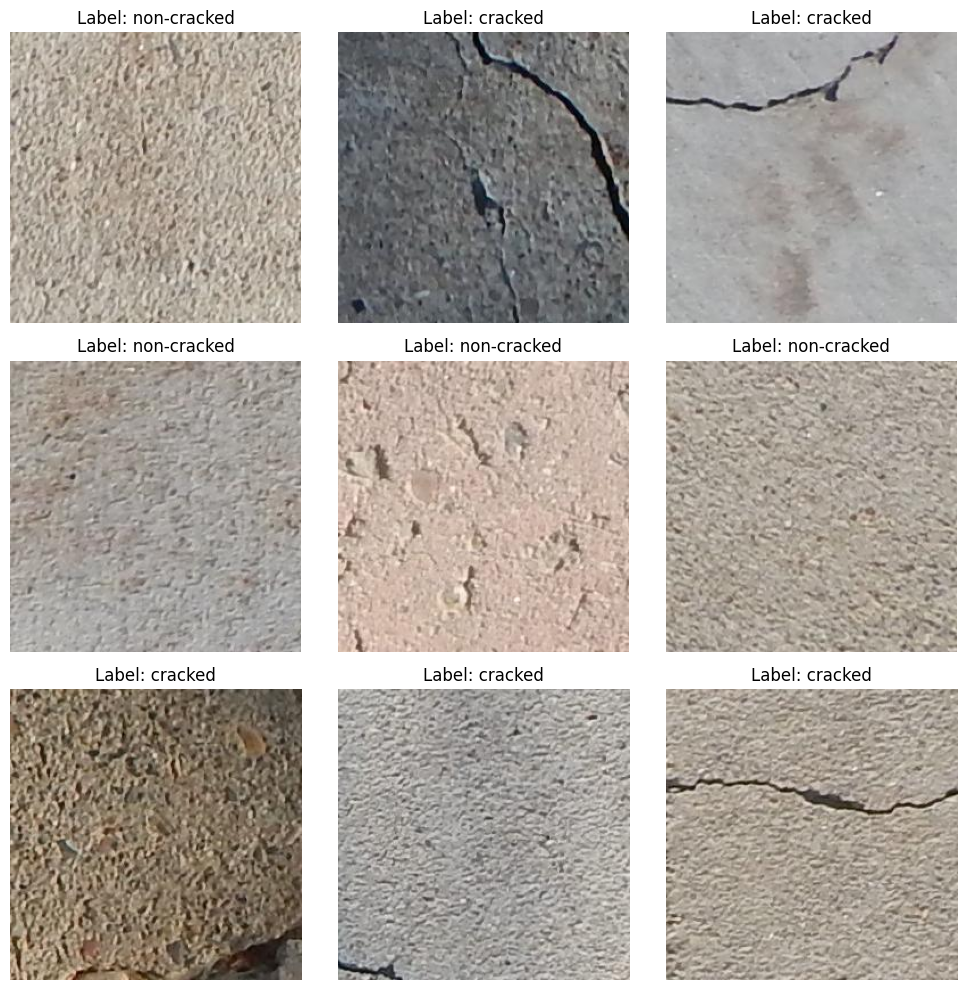

In [6]:
show_df(df=df, n_samples=9)

# Initialize Dataset and Dataloader for Training

In [7]:
class CrackDataset(Dataset):
    def __init__(self, df, dataset_name, transform=None):
        super().__init__()
        self.df_data = df.values
        self.dataset_name = dataset_name
        self.transform = transform

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, idx):
        img_path, label = self.df_data[idx]
        image = Image.open(img_path).convert("RGB")
        label = 1 if label=='cracked' else 0

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [8]:
# define the input image dimensions
IMG_SIZE = 224

# define the batch size
BATCH_SIZE = 32

if PRETRAINED:
    MEAN, STD = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225) # ImageNet normalization
else:
    MEAN, STD = calculate_mean_std(train_df.copy())

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD), 
    ]),
    'valid': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD),
    ])
}

dataloaders = {
    'train': DataLoader(CrackDataset(train_df, DATASET_NAME, transform=data_transforms['train']), 
                        batch_size=BATCH_SIZE, shuffle=True, 
                        pin_memory=PIN_MEMORY),
    'valid': DataLoader(CrackDataset(valid_df, DATASET_NAME, transform=data_transforms['valid']), 
                        batch_size=BATCH_SIZE, shuffle=False, 
                        pin_memory=PIN_MEMORY),
    'test': DataLoader(CrackDataset(test_df, DATASET_NAME, transform=data_transforms['valid']), 
                       batch_size=1, shuffle=False,
                       pin_memory=PIN_MEMORY)
}

Images batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: 32


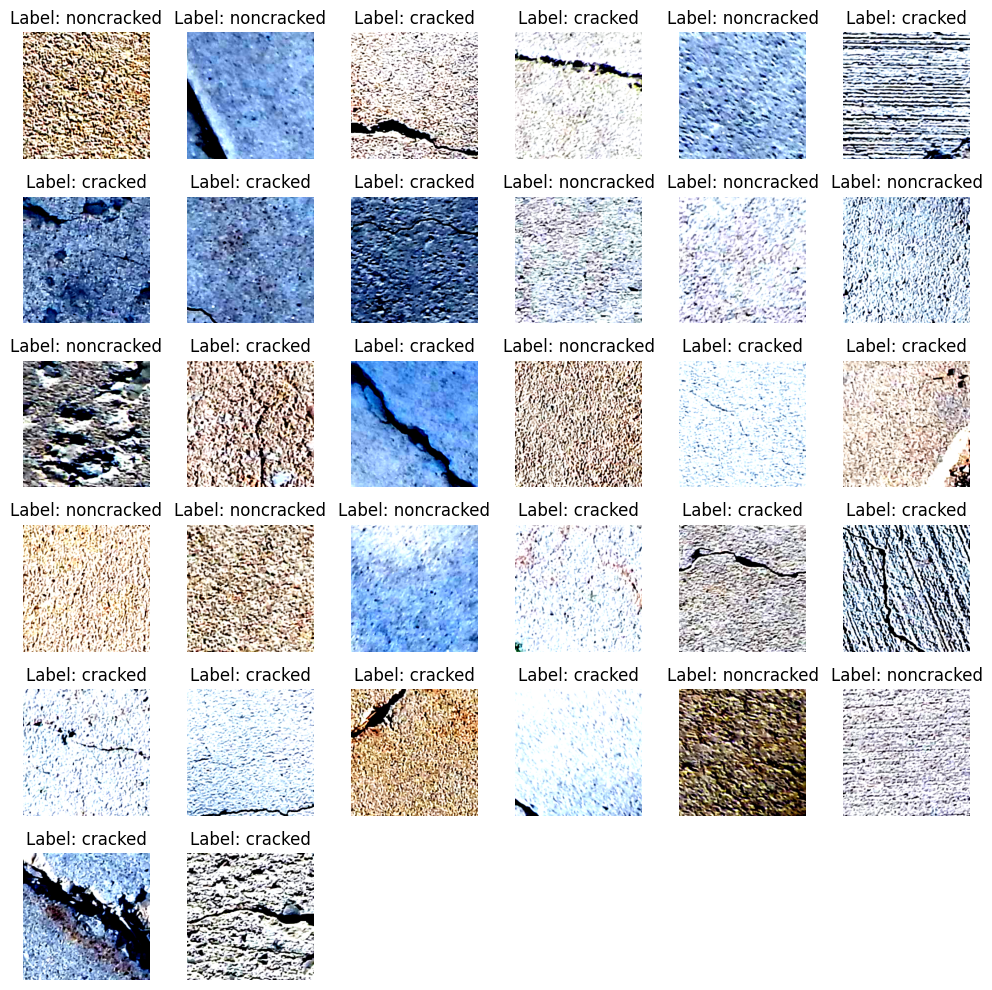

In [9]:
show_dl(dataloaders['train'])

# ViT (Vision Transformer) Architecture

In [10]:
from torchvision import models

size = 'base'
patch_size = 16
pretrained = False

valid_sizes = {"base": [16, 32], "large": [16, 32], "huge": [14]}
if size not in valid_sizes or patch_size not in valid_sizes[size]:
    raise ValueError(f"Invalid combination of size '{size}' and patch_size {patch_size}.")

# Load appropriate model based on size and patch size
weights = 'DEFAULT' if pretrained else None

model_func = {
    ("base", 16): models.vit_b_16,
    ("base", 32): models.vit_b_32,
    ("large", 16): models.vit_l_16,
    ("large", 32): models.vit_l_32,
    ("huge", 14): models.vit_h_14,
}[(size, patch_size)]
model = model_func(weights=weights)

# print(model)

trainable_layers = 10

if pretrained: # pretrained True
    if trainable_layers is not None: # trainable_layers -1 - > all
        for param in model.parameters():
            param.requires_grad = False # Freeze all layers
    # Defrost encoder layers 1 to 11 (inclusive)
    for name, param in model.named_parameters():
        if 'encoder.layers.' in name and (int(name.split('.')[2]) >= 1 and int(name.split('.')[2]) <= trainable_layers):
            param.requires_grad = True

for param in model.parameters():
    print(param.requires_grad)


# # Update head layer for classification
# num_classes = len(df.label.unique())
# num_features_in = model.heads.head.in_features
# model.heads.head = torch.nn.Linear(num_features_in, num_classes)


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [42]:
# i = 0
# for name, param in model.encoder.layers.named_parameters():
#     print(name)

model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [49]:
for name, param in model.encoder.layers.named_parameters():
    layer_num = int(name.split('.')[0].replace('encoder_layer_', ''))
    print(layer_num)
        # if 1 <= layer_num <= trainable_layers:
        #     param.requires_grad = True
    # if 'encoder.layers.' in name and (int(name.split('.')[2]) >= 1 and int(name.split('.')[2]) <= trainable_layers):
    #     param.requires_grad = True

0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
11
11
11
11


In [23]:
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [26]:
for name, param in model.named_parameters():
    if param.requires_grad == True:
        print(name)

class_token
conv_proj.weight
conv_proj.bias
encoder.pos_embedding
encoder.layers.encoder_layer_0.ln_1.weight
encoder.layers.encoder_layer_0.ln_1.bias
encoder.layers.encoder_layer_0.self_attention.in_proj_weight
encoder.layers.encoder_layer_0.self_attention.in_proj_bias
encoder.layers.encoder_layer_0.self_attention.out_proj.weight
encoder.layers.encoder_layer_0.self_attention.out_proj.bias
encoder.layers.encoder_layer_0.ln_2.weight
encoder.layers.encoder_layer_0.ln_2.bias
encoder.layers.encoder_layer_0.mlp.0.weight
encoder.layers.encoder_layer_0.mlp.0.bias
encoder.layers.encoder_layer_0.mlp.3.weight
encoder.layers.encoder_layer_0.mlp.3.bias
encoder.layers.encoder_layer_1.ln_1.weight
encoder.layers.encoder_layer_1.ln_1.bias
encoder.layers.encoder_layer_1.self_attention.in_proj_weight
encoder.layers.encoder_layer_1.self_attention.in_proj_bias
encoder.layers.encoder_layer_1.self_attention.out_proj.weight
encoder.layers.encoder_layer_1.self_attention.out_proj.bias
encoder.layers.encoder_lay

In [25]:
params_to_update = list(filter(lambda p: p.requires_grad, model.parameters()))

152

In [26]:
# params_to_update = model.parameters()
# print("Params to learn:\n")
# if feature_extract:
#     params_to_update = []
#     for name,param in model.named_parameters():
#         if param.requires_grad == True:
#             params_to_update.append(param)
#             print(name)
# else:
#     for name,param in model.named_parameters():
#         if param.requires_grad == True:
#             print(name)

# Fine-tune ViT

In [13]:
from torchvision import models

model = models.vit_b_16(weights='DEFAULT')

for param in model.parameters():
    param.requires_grad = False
    
num_classes = len(df.label.unique())
        
num_features_in = model.heads.head.in_features
model.heads.head = torch.nn.Linear(num_features_in, num_classes)

model.name = "vit_b_16"

In [14]:
# initialize learning rate, number of epochs to train for, and the batch size
INIT_LR = 2.5e-1
MOMENTUM = 0.9

# Send the model to GPU
model = model.to(DEVICE)

# Setup the loss function
criterion = torch.nn.CrossEntropyLoss()

# Model parameters where requires grad is True
params_to_tune = [param for param in model.parameters() if param.requires_grad]

# Observe that all parameters are being optimized
optimizer = optim.SGD(params_to_tune, lr=INIT_LR, momentum=MOMENTUM)

# Update learning rate once validation loss stop decreasing
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=3, threshold=2.5e-5)

In [12]:
# model = models.vit_b_16(weights='DEFAULT')

# for param in model.parameters():
#     param.requires_grad = False
    
# num_classes = len(df.labels.unique())
        
# num_features_in = model.heads.head.in_features
# model.heads.head = torch.nn.Linear(num_features_in, num_classes)

# # initialize learning rate, number of epochs to train for, and the batch size
# INIT_LR = 2.5e-3
# MOMENTUM = 0.9

# # Send the model to GPU
# model = model.to(DEVICE)

# # Setup the loss function
# criterion = torch.nn.CrossEntropyLoss()

# # Model parameters where requires grad is True
# params_to_tune = [param for param in model.parameters() if param.requires_grad]

# # Observe that all parameters are being optimized
# optimizer = optim.SGD(params_to_tune, lr=INIT_LR, momentum=MOMENTUM)

# NUM_EPOCHS = 10

# train_inputs, train_labels = next(iter(dataloaders['train']))
# val_inputs, val_labels = next(iter(dataloaders['valid']))

# # Train the model for the specified number of epochs
# for epoch in range(NUM_EPOCHS):
#     print(f'Epoch {epoch}')
#     # Set the model to train mode
#     model.train()

#     # Initialize the running loss and accuracy
#     batch_train_loss = 0.0
#     batch_train_corrects = 0

#     # # Iterate over the batches of the train loader
#     # for inputs, labels in train_loader:
#     # Move the inputs and labels to the device
#     train_inputs = train_inputs.to(DEVICE)
#     train_labels = train_labels.to(DEVICE)

#     # Forward pass
#     outputs = model(train_inputs)
#     _, preds = torch.max(outputs, 1)
#     loss = criterion(outputs, train_labels)
    
#     # Zero the optimizer gradients
#     optimizer.zero_grad()
    
#     # Backward pass and optimizer step
#     loss.backward()
#     optimizer.step()

#     # Update the running loss and accuracy
#     batch_train_loss += loss.item() * train_inputs.size(0)
#     batch_train_corrects += torch.sum(preds == train_labels.data)

# #     # Calculate the train loss and accuracy
# #     train_dataset_len = dataloaders['train'].dataset.__len__()
# #     train_epoch_loss = batch_loss / train_dataset_len
# #     train_epoch_acc = batch_corrects.double() / train_dataset_len

#     print(f'Train Loss: {batch_train_loss}, Train Accuracy: {batch_train_corrects/32}')
    
#     # Set the model to evaluation mode
#     model.eval()

#     # Initialize the running loss and accuracy
#     batch_val_loss = 0.0
#     batch_val_corrects = 0

#     # Iterate over the batches of the validation loader
#     with torch.no_grad():
# #         for inputs, labels in val_loader:
# #             # Move the inputs and labels to the device
#         val_inputs = val_inputs.to(DEVICE)
#         val_labels = val_labels.to(DEVICE)

#         # Forward pass
#         outputs = model(val_inputs)
#         _, preds = torch.max(outputs, 1)
#         loss = criterion(outputs, val_labels)

#         # Update the running loss and accuracy
#         batch_val_loss += loss.item() * val_inputs.size(0)
#         batch_val_corrects += torch.sum(preds == val_labels.data)
        
#     print(f'Validation Loss: {batch_val_loss}, Validation Accuracy: {batch_val_corrects/32}\n')



#     # Calculate the validation loss and accuracy
# #     val_loss = running_loss / len(val_dataset)
# #     val_acc = running_corrects.double() / len(val_dataset)

In [15]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

NUM_EPOCHS = 100

train_hist = train(model, NUM_EPOCHS, dataloaders, criterion, optimizer, scheduler, device=DEVICE)

Epoch [1/100], lr: 0.25, train loss: 4.1632, train acc: 0.8066, val loss: 12.1726, val acc: 0.6475
Epoch [2/100], lr: 0.25, train loss: 5.1921, train acc: 0.8329, val loss: 4.6192, val acc: 0.8506
Epoch [3/100], lr: 0.25, train loss: 4.1230, train acc: 0.8435, val loss: 4.5539, val acc: 0.8467
Epoch [4/100], lr: 0.25, train loss: 3.9578, train acc: 0.8514, val loss: 5.8944, val acc: 0.8289
Epoch [5/100], lr: 0.25, train loss: 4.1545, train acc: 0.8538, val loss: 4.0233, val acc: 0.8340
Epoch [6/100], lr: 0.25, train loss: 2.9691, train acc: 0.8744, val loss: 2.9492, val acc: 0.8442
Epoch [7/100], lr: 0.25, train loss: 2.9469, train acc: 0.8698, val loss: 2.7398, val acc: 0.8659
Epoch [8/100], lr: 0.25, train loss: 3.2155, train acc: 0.8615, val loss: 4.7962, val acc: 0.8378
Epoch [9/100], lr: 0.25, train loss: 2.7207, train acc: 0.8799, val loss: 2.4166, val acc: 0.8736
Epoch [10/100], lr: 0.25, train loss: 2.5089, train acc: 0.8818, val loss: 2.5613, val acc: 0.8672
Epoch [11/100], lr

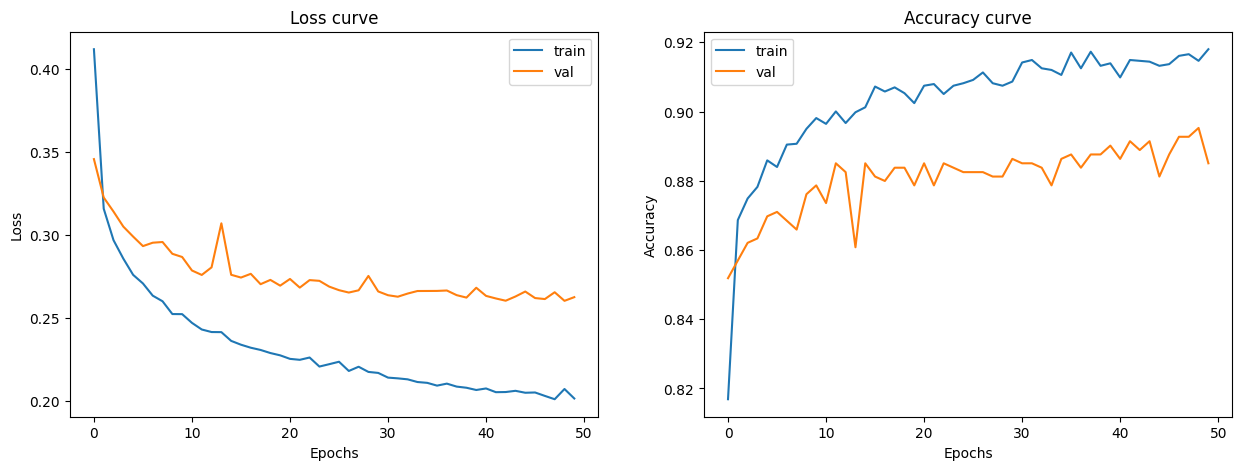

In [14]:
plot_acc_loss_curve(train_hist)

In [15]:
model.eval()

batch_loss = 0.0
batch_corrects = 0
# Iterate over the batches of the validation loader
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        # Move the inputs and labels to the device
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Update the running loss and accuracy
        batch_loss += loss.item() * inputs.size(0)
        batch_corrects += torch.sum(preds == labels.data)

test_dataset_len = dataloaders['test'].dataset.__len__()
test_loss = batch_loss / test_dataset_len
test_acc = batch_corrects.double() / test_dataset_len

print(f"Test loss: {test_loss}, test acc: {test_acc}")

Test loss: 0.27198577188719464, test acc: 0.8965517241379309


In [23]:
# def train_one_epoch(model, dataloaders, criterion, optimizer):
#     for phase in ['train', 'valid']:
#         if phase == 'train':
#             model.train()  # Set model to training mode
#         else:
#             model.eval()   # Set model to evaluate mode

#         running_loss = 0.0
#         running_corrects = 0

#         # Iterate over data.
#         for inputs, labels in dataloaders[phase]:
#             inputs = inputs.to(DEVICE)
#             labels = labels.to(DEVICE)

#             # zero the parameter gradients
#             optimizer.zero_grad()

#             # forward
#             # track history if only in train
#             with torch.set_grad_enabled(phase=='train'):
#                 # Get model outputs and calculate loss
#                 # Special case for inception because in training it has an auxiliary output. In train
#                 #   mode we calculate the loss by summing the final output and the auxiliary output
#                 #   but in testing we only consider the final output.
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)

#                 _, preds = torch.max(outputs, 1)

#                 # backward + optimize only if in training phase
#                 if phase == 'train':
#                     loss.backward()
#                     optimizer.step()

#             # statistics
#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)

#         epoch_loss = running_loss / len(dataloaders[phase].dataset)
#         epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
        
#         return epoch_loss, epoch_acc

# def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
#     since = time.time()

#     val_acc_history = []
    
#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#         print('-' * 10)

        

#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

#             # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())
#             if phase == 'val':
#                 val_acc_history.append(epoch_acc)

#         print()

#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model, val_acc_history

In [25]:
# Train and evaluate
model_ft, hist = train_model(model, dataloaders, criterion, optimizer, num_epochs=NUM_EPOCHS)

Epoch 0/99
----------


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
